In [48]:
from __future__ import print_function
from numpy import *
%pylab inline
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# evaluates cubic bezier at t, return point
def q(ctrlPoly, t):
    return (1.0-t)**3 * ctrlPoly[0] + 3*(1.0-t)**2 * t * ctrlPoly[1] + 3*(1.0-t)* t**2 * ctrlPoly[2] + t**3 * ctrlPoly[3]


# evaluates cubic bezier first derivative at t, return point
def qprime(ctrlPoly, t):
    return 3*(1.0-t)**2 * (ctrlPoly[1]-ctrlPoly[0]) + 6*(1.0-t) * t * (ctrlPoly[2]-ctrlPoly[1]) + 3*t**2 * (ctrlPoly[3]-ctrlPoly[2])


# evaluates cubic bezier second derivative at t, return point
def qprimeprime(ctrlPoly, t):
    return 6*(1.0-t) * (ctrlPoly[2]-2*ctrlPoly[1]+ctrlPoly[0]) + 6*(t) * (ctrlPoly[3]-2*ctrlPoly[2]+ctrlPoly[1])




Populating the interactive namespace from numpy and matplotlib


In [53]:
""" Python implementation of
    Algorithm for Automatically Fitting Digitized Curves
    by Philip J. Schneider
    "Graphics Gems", Academic Press, 1990
"""
from __future__ import print_function
from scipy.special import comb
from numpy import *
#import bezier


# Fit one (ore more) Bezier curves to a set of points
def fitCurve(points, maxError):
    leftTangent = normalize(points[1] - points[0])
    rightTangent = normalize(points[-2] - points[-1])
    return fitCubic(points, leftTangent, rightTangent, maxError)


def fitCubic(points, leftTangent, rightTangent, error):
    # Use heuristic if region only has two points in it
    if (len(points) == 2):
        dist = linalg.norm(points[0] - points[1]) / 3.0
        bezCurve = [points[0], points[0] + leftTangent * dist, points[1] + rightTangent * dist, points[1]]
        return [bezCurve]

    # Parameterize points, and attempt to fit curve
    u = chordLengthParameterize(points)
    bezCurve = generateBezier(points, u, leftTangent, rightTangent)
    # Find max deviation of points to fitted curve
    maxError, splitPoint = computeMaxError(points, bezCurve, u)
    if maxError < error:
        return [bezCurve]

    # If error not too large, try some reparameterization and iteration
    if maxError < error**2:
        for i in range(20):
            uPrime = reparameterize(bezCurve, points, u)
            bezCurve = generateBezier(points, uPrime, leftTangent, rightTangent)
            maxError, splitPoint = computeMaxError(points, bezCurve, uPrime)
            if maxError < error:
                return [bezCurve]
            u = uPrime

    # Fitting failed -- split at max error point and fit recursively
    beziers = []
    centerTangent = normalize(points[splitPoint-1] - points[splitPoint+1])
    beziers += fitCubic(points[:splitPoint+1], leftTangent, centerTangent, error)
    beziers += fitCubic(points[splitPoint:], -centerTangent, rightTangent, error)

    return beziers


def generateBezier(points, parameters, leftTangent, rightTangent):
    bezCurve = [points[0], None, None, points[-1]]

    # compute the A's
    A = zeros((len(parameters), 2, 2))
    for i, u in enumerate(parameters):
        A[i][0] = leftTangent  * 3*(1-u)**2 * u
        A[i][1] = rightTangent * 3*(1-u)    * u**2

    # Create the C and X matrices
    C = zeros((2, 2))
    X = zeros(2)

    for i, (point, u) in enumerate(zip(points, parameters)):
        C[0][0] += dot(A[i][0], A[i][0])
        C[0][1] += dot(A[i][0], A[i][1])
        C[1][0] += dot(A[i][0], A[i][1])
        C[1][1] += dot(A[i][1], A[i][1])

        tmp = point - q([points[0], points[0], points[-1], points[-1]], u)

        X[0] += dot(A[i][0], tmp)
        X[1] += dot(A[i][1], tmp)

    # Compute the determinants of C and X
    det_C0_C1 = C[0][0] * C[1][1] - C[1][0] * C[0][1]
    det_C0_X  = C[0][0] * X[1] - C[1][0] * X[0]
    det_X_C1  = X[0] * C[1][1] - X[1] * C[0][1]

    # Finally, derive alpha values
    alpha_l = 0.0 if det_C0_C1 == 0 else det_X_C1 / det_C0_C1
    alpha_r = 0.0 if det_C0_C1 == 0 else det_C0_X / det_C0_C1

    # If alpha negative, use the Wu/Barsky heuristic (see text) */
    # (if alpha is 0, you get coincident control points that lead to
    # divide by zero in any subsequent NewtonRaphsonRootFind() call. */
    segLength = linalg.norm(points[0] - points[-1])
    epsilon = 1.0e-6 * segLength
    if alpha_l < epsilon or alpha_r < epsilon:
        # fall back on standard (probably inaccurate) formula, and subdivide further if needed.
        bezCurve[1] = bezCurve[0] + leftTangent * (segLength / 3.0)
        bezCurve[2] = bezCurve[3] + rightTangent * (segLength / 3.0)

    else:
        # First and last control points of the Bezier curve are
        # positioned exactly at the first and last data points
        # Control points 1 and 2 are positioned an alpha distance out
        # on the tangent vectors, left and right, respectively
        bezCurve[1] = bezCurve[0] + leftTangent * alpha_l
        bezCurve[2] = bezCurve[3] + rightTangent * alpha_r

    return bezCurve


def reparameterize(bezier, points, parameters):
    return [newtonRaphsonRootFind(bezier, point, u) for point, u in zip(points, parameters)]


def newtonRaphsonRootFind(bez, point, u):
    """
       Newton's root finding algorithm calculates f(x)=0 by reiterating
       x_n+1 = x_n - f(x_n)/f'(x_n)

       We are trying to find curve parameter u for some point p that minimizes
       the distance from that point to the curve. Distance point to curve is d=q(u)-p.
       At minimum distance the point is perpendicular to the curve.
       We are solving
       f = q(u)-p * q'(u) = 0
       with
       f' = q'(u) * q'(u) + q(u)-p * q''(u)

       gives
       u_n+1 = u_n - |q(u_n)-p * q'(u_n)| / |q'(u_n)**2 + q(u_n)-p * q''(u_n)|
    """
    d = q(bez, u)-point
    numerator = (d * qprime(bez, u)).sum()
    denominator = (qprime(bez, u)**2 + d * qprimeprime(bez, u)).sum()

    if denominator == 0.0:
        return u
    else:
        return u - numerator/denominator


def chordLengthParameterize(points):
    u = [0.0]
    for i in range(1, len(points)):
        u.append(u[i-1] + linalg.norm(points[i] - points[i-1]))

    for i, _ in enumerate(u):
        u[i] = u[i] / u[-1]

    return u


def computeMaxError(points, bez, parameters):
    maxDist = 0.0
    splitPoint = len(points)/2
    for i, (point, u) in enumerate(zip(points, parameters)):
        dist = linalg.norm(q(bez, u)-point)**2
        if dist > maxDist:
            maxDist = dist
            splitPoint = i

    return maxDist, splitPoint


def normalize(v):
    return v / linalg.norm(v)

def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.
       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000
        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])
    print(xPoints)
    print(yPoints)
    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


[[ 1073. -1058.]
 [ 1072. -1085.]
 [ 1066. -1117.]
 [ 1052. -1152.]
 [ 1030. -1196.]
 [ 1009. -1242.]
 [  994. -1286.]
 [  980. -1317.]
 [  971. -1336.]
 [  968. -1344.]
 [  966. -1339.]
 [  972. -1340.]
 [  978. -1320.]
 [  991. -1298.]
 [ 1003. -1266.]
 [ 1016. -1231.]
 [ 1021. -1184.]
 [ 1030. -1143.]
 [ 1040. -1108.]
 [ 1049. -1077.]
 [ 1055. -1049.]
 [ 1058. -1021.]
 [ 1064. -1006.]
 [ 1071. -1006.]
 [ 1071. -1006.]
 [ 1074. -1013.]
 [ 1083. -1042.]
 [ 1097. -1082.]
 [ 1114. -1124.]
 [ 1134. -1172.]
 [ 1158. -1225.]
 [ 1181. -1280.]
 [ 1200. -1327.]
 [ 1218. -1365.]
 [ 1220. -1373.]
 [ 1223. -1376.]
 [ 1221. -1372.]
 [ 1220. -1369.]
 [ 1215. -1353.]
 [ 1204. -1330.]]
[1073.         1072.13140229 1073.01737436 1066.        ]
[-1058.         -1081.45213808 -1093.49179591 -1117.        ]
[1066.         1048.82321721 1015.74487003  994.        ]
[-1117.         -1174.54222233 -1229.76326715 -1286.        ]
[994.         986.7941121  951.87162036 966.        ]
[-1286.         -1304.635

KeyError: 0

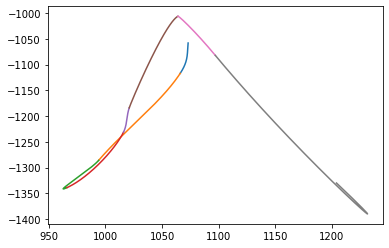

In [60]:
dd = pd.read_excel("C:\\Users\\RAJAT BHARDWAJ\\Desktop\\project\\datafile.xls")
prev = 0;
curr = 0;
start = 0;
time = 0;
for i in dd.index:
    if(dd.loc[i].X_value == '\n'):
        curr = i;
        d1 = dd[prev:curr]
        #rgb = (random.random(),random.random(),random.random())
        #plt.plot(d1.X_value.astype(int),-1*d1.Y_value.astype(int),c=numpy.random.rand(3,))
        prev = curr + 1
        
        points = []

        x_points = []
        x_points.append(d1.X_value.astype(float))
        y_points = []
        y_points.append(d1.Y_value.astype(float))
        
        length = prev
        for j in range(start,length-1):
            each = []
            each.append(x_points[0][j])
            each.append(-1*y_points[0][j])
            points.append(each)

        poin = np.array(points)
        print(poin)
        beziers = fitCurve(poin, 100.0)
        
        for bezier in beziers:
            #print(bezier)
            xPoints = np.array([p[0] for p in bezier])
            yPoints = np.array([p[1] for p in bezier])
            #print(xPoints)
            #print(yPoints)
            xvals, yvals = bezier_curve(bezier, nTimes=1000)
            plt.plot(xvals, yvals)
            #plt.plot(xPoints, yPoints, "ro")
            #for nr in range(len(bezier)):
                #plt.text(bezier[nr][0], bezier[nr][1], nr)

                
plt.show()        